In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
import pandas as pd

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
# from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

import h5py


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from util.sphot_workflow import plot_image_logscale

In [4]:
f555w = fits.open('SH0ES_N5584_reprojected_iter2/F555W.fits')[0].data
f814w = fits.open('SH0ES_N5584_reprojected_iter2/F814W.fits')[0].data
f090w = fits.open('SH0ES_N5584_reprojected_iter2/F090W.fits')[0].data
f150w = fits.open('SH0ES_N5584_reprojected_iter2/F150W.fits')[0].data
f160w = fits.open('SH0ES_N5584_reprojected_iter2/F160W.fits')[0].data
f277w = fits.open('SH0ES_N5584_reprojected_iter2/F277W.fits')[0].data
wcs = WCS(fits.open('SH0ES_N5584_reprojected_iter2/F090W.fits')[0].header)

In [5]:
images = [f555w, f814w, f090w, f150w, f160w, f277w]
filternames = ['F555W', 'F814W', 'F090W', 'F150W', 'F160W', 'F277W']
pix_scale = 0.03 * u.arcsec / u.pixel

In [6]:
N5584_ra = 215.599 * u.deg
N5584_dec = -0.3878 * u.deg
N5584_coord = SkyCoord(ra=N5584_ra, dec=N5584_dec)
N5584_size = 2.4 * u.arcmin

In [7]:
def generate_cutout(images,filternames,wcs,center_coord,cutout_size,offset_min,offset_max,maxiter=15,plot=True):
    ''' keep randomly generating cutouts until a valid one is found
    Inputs:
        images (list): list of 2D arrays (images)
        filternames (list): list of strings representing filter names
        wcs (WCS): astropy WCS of images (assumed to be the same for all images)
        center_coord (SkyCoord): astropy SkyCoord
        cutout_size (tuple): (Nrows,Ncols)
        offset_min (float): minimum offset in arcmin
        offset_max (float): maximum offset in arcmin
        maxiter (int): maximum number of iterations to try before giving up
    '''
    success = False
    for Niter in range(maxiter):
        try:
            offset_angle = np.random.uniform(0, 360) * u.deg
            offset_separation = np.random.uniform(offset_min, offset_max) * u.arcmin
            cutout_loc = center_coord.directional_offset_by(offset_angle, offset_separation)
            cutouts = []
            for img,filtername in zip(images,filternames):
                cutout = Cutout2D(img, cutout_loc, cutout_size, wcs=wcs, mode='strict')
                assert (~np.isfinite(cutout.data)).sum() == 0 #<= 0.05 * cutout_size[0] * cutout_size[1]
                cutouts.append(cutout)
            success = True
            break
        except Exception:
            if Niter+1 == maxiter:
                print(f'{maxiter} iterations failed to produce a valid cutout. Exiting.')
                success = False
                cutouts = None
            continue

    if success and plot:
        fig,axes = plt.subplots(2,3,figsize=(15,10))
        for cutout,ax,filtername in zip(cutouts,axes.ravel(),filternames):
            plot_image_logscale(cutout.data,ax=ax)
            ax.set_title(filtername) 

    return cutouts

In [16]:
for i in np.arange(10,501):
    try:
        objname = str(i).zfill(3)
        cutouts = generate_cutout(images,filternames,wcs,
                                    center_coord = N5584_coord,
                                    cutout_size = (256,256), # pixels
                                    offset_min = 0.3, # arcsec
                                    offset_max = 3.0, # arcsec
                                    plot = True
                                    )
        plt.savefig(f'cutouts_raw/images/{objname}.png',dpi=100,bbox_inches='tight')
        plt.close()

        # save
        with h5py.File(f'cutouts_raw/{objname}.h5', 'w') as f:
            for cutout, filtername in zip(cutouts, filternames):
                f.create_dataset(filtername, data=cutout.data)
    except Exception:
        continue

15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.
15 iterations failed to produce a valid cutout. Exiting.


# read

In [22]:
with h5py.File('cutouts_raw/11.h5', 'r') as f:
    print(f.keys())
    f555w_data = f['F555W'][:]
    f814w_data = f['F814W'][:]
    f090w_data = f['F090W'][:]
    f150w_data = f['F150W'][:]
    f160w_data = f['F160W'][:]
    f277w_data = f['F277W'][:]

<KeysViewHDF5 ['F090W', 'F150W', 'F160W', 'F277W', 'F555W', 'F814W']>


(<matplotlib.colors.LogNorm at 0x179f1ad50>, 0)

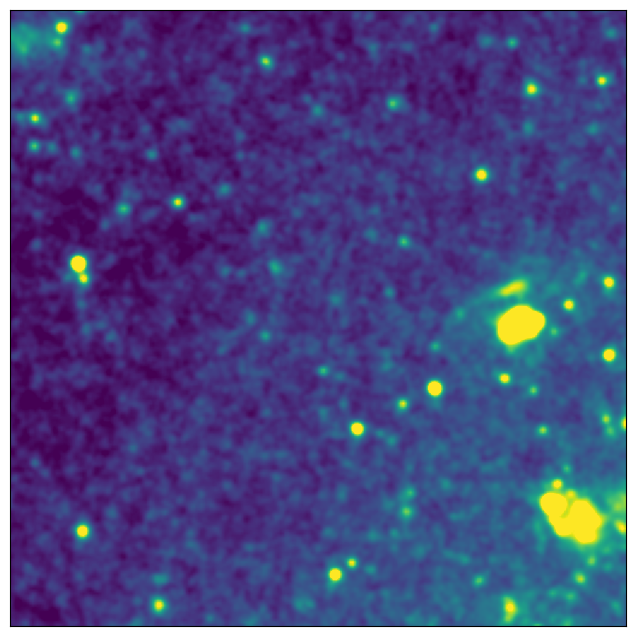

In [26]:
plot_image_logscale(f555w_data)